In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
from torchvision.models import resnet18

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [3]:
img_to_tensor = T.ToTensor()
resize = T.Resize((224, 224), antialias=None)
normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

def tensor_to_img(img_tensor):
    if img_tensor.shape[0] == 1:
        img_tensor = img_tensor.squeeze(0)
    img = img_tensor.detach().cpu().numpy().swapaxes(0, 1).swapaxes(1, 2)
    img = np.clip(img, 0, 1)
    return np.array(img * 255, dtype=np.uint8)

In [4]:
# author made a mistake and did not use `.eval()` mode, so the model is in training mode
# we will need to deal with this in the adversarial attack
model = resnet18()
model.fc = nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load("../data/i-hate-anime-girls-osugaming-2024/model.pt"))
model.to(device)

img_original = np.array(Image.open("../data/i-hate-anime-girls-osugaming-2024/hitorigoto.png"))
img_original_tensor = img_to_tensor(img_original).unsqueeze(0).to(device)

In [5]:
n_iterations = 1250
eps = 7. / 255.
bs = 32 # not needed

x = img_original_tensor.clone().detach().requires_grad_(True)

# made use of lr_scheduler to reduce the learning rate when the loss stops decreasing
# this helps model converge as this problem is hard to optimize
optimizer = torch.optim.Adam([x], lr=5e-1)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, verbose=True, factor=0.5)
loss_func = nn.BCEWithLogitsLoss()

def forward(x):
    x = resize(x)
    x = normalize(x)
    x = model(x)
    return x

for iteration in range(n_iterations):
    optimizer.zero_grad()
    model.zero_grad() # this is the fix for the author's mistake

    logits = forward(torch.cat([x] * bs, dim=0)) # not needed
    loss = loss_func(logits, torch.ones_like(logits)) # maximize the output of the model
    loss.backward()

    optimizer.step()
    lr_scheduler.step(loss)

    x.data = torch.clamp(x.data, img_original_tensor - eps, img_original_tensor + eps)

    if iteration % (n_iterations // 20) == 0:
        current_img = tensor_to_img(x)
        diff = np.abs(current_img.astype(np.int32) - img_original.astype(np.int32)).astype(np.uint8)
        min_d, mean_d, max_d = diff.min(), diff.mean(), diff.max()

        print(
            f"Iteration: {iteration: <3} | Loss: {loss.item(): .4f} | Prediction: {torch.sigmoid(torch.mean(logits)).item(): .4f} |",
            f"Min diff: {min_d: .2f} | Mean diff: {mean_d: .2f} | Max diff: {max_d: .2f}"
        )

Iteration: 0   | Loss:  2.0104 | Prediction:  0.1339 | Min diff:  0.00 | Mean diff:  4.80 | Max diff:  8.00
Iteration: 62  | Loss:  0.8156 | Prediction:  0.4424 | Min diff:  0.00 | Mean diff:  4.51 | Max diff:  8.00
Iteration: 124 | Loss:  0.9748 | Prediction:  0.3773 | Min diff:  0.00 | Mean diff:  4.53 | Max diff:  8.00
Iteration: 186 | Loss:  0.7371 | Prediction:  0.4785 | Min diff:  0.00 | Mean diff:  4.52 | Max diff:  8.00
Epoch 00223: reducing learning rate of group 0 to 2.5000e-01.
Iteration: 248 | Loss:  0.5386 | Prediction:  0.5836 | Min diff:  0.00 | Mean diff:  4.48 | Max diff:  8.00
Epoch 00284: reducing learning rate of group 0 to 1.2500e-01.
Iteration: 310 | Loss:  0.8253 | Prediction:  0.4381 | Min diff:  0.00 | Mean diff:  3.96 | Max diff:  8.00
Epoch 00350: reducing learning rate of group 0 to 6.2500e-02.
Iteration: 372 | Loss:  0.3272 | Prediction:  0.7209 | Min diff:  0.00 | Mean diff:  3.88 | Max diff:  7.00
Epoch 00415: reducing learning rate of group 0 to 3.1250e-

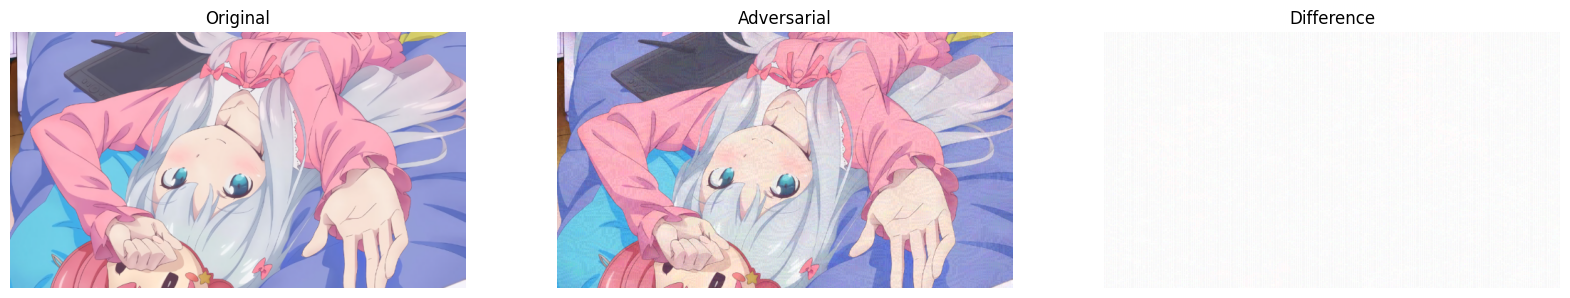

In [6]:
delta_img = np.abs(np.array(tensor_to_img(x)).astype(np.int32) - img_original.astype(np.int32)).astype(np.uint8)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
titles = ["Original", "Adversarial", "Difference"]
imgs = [img_original, np.array(tensor_to_img(x)), ~delta_img]
for i in range(3):
    ax[i].imshow(imgs[i])
    ax[i].set_title(titles[i])
    ax[i].axis("off")

plt.show()